In [1]:
import rasterio
from rasterio.plot import show as rastershow
import rioxarray
from matplotlib import pyplot as plt
import numpy as np
import os
import torch
import itertools

In [2]:
import sys
sys.path.append('../../')
from deeptrees.dataloading.datasets import TreeCrownDelineationBaseDataset
from deeptrees.model.deeptrees_model import DeepTreesModel
from deeptrees.modules.utils import predict_on_tile, compute_pyramid_patch_weight_loss

/home/k/k202141/.conda/envs/deeptree/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = DeepTreesModel(5)

In [4]:
ptw = torch.jit.load('/work/ka1176/shared_data/2024-ufz-deeptree/pretrained_models/tcd-20cm-RGBI-v1/Unet-resnet18_epochs=209_lr=0.0001_width=224_bs=32_divby=255_custom_color_augs_k=0_jitted.pt')
model.tcd_backbone.load_state_dict(ptw.state_dict())

<All keys matched successfully>

In [5]:
model = model.eval();

In [6]:
small_tile_path = '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/pool_tiles/tile_4_0.tif'
large_tile_path = '/work/ka1176/shared_data/2024-ufz-deeptree/Halle-DOP20-2022/dop20rgbi_32_692_5706_2_st_2022.tif'

In [7]:
def create_raster_tensor(tile_path):
    '''Replacement for dataloader'''
    tile = rioxarray.open_rasterio(tile_path)
    tile = tile / 255
    tile = TreeCrownDelineationBaseDataset.concatenate_ndvi_to_raster(tile)

    return torch.from_numpy(tile.data).unsqueeze(0).to(torch.float)

## Small tile

In [8]:
t = create_raster_tensor(small_tile_path)

/home/k/k202141/.conda/envs/deeptree/lib/python3.12/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [9]:
%time output0 = predict_on_tile(model, t, max_patch_size=256, stride=256)
%time output1 = predict_on_tile(model, t, max_patch_size=256, stride=128)
%time output2 = predict_on_tile(model, t, max_patch_size=256, stride=64)

CPU times: user 30.5 s, sys: 1.59 s, total: 32.1 s
Wall time: 1.93 s
CPU times: user 35.1 s, sys: 8.85 s, total: 43.9 s
Wall time: 710 ms
CPU times: user 1min 56s, sys: 42.6 s, total: 2min 38s
Wall time: 2.71 s


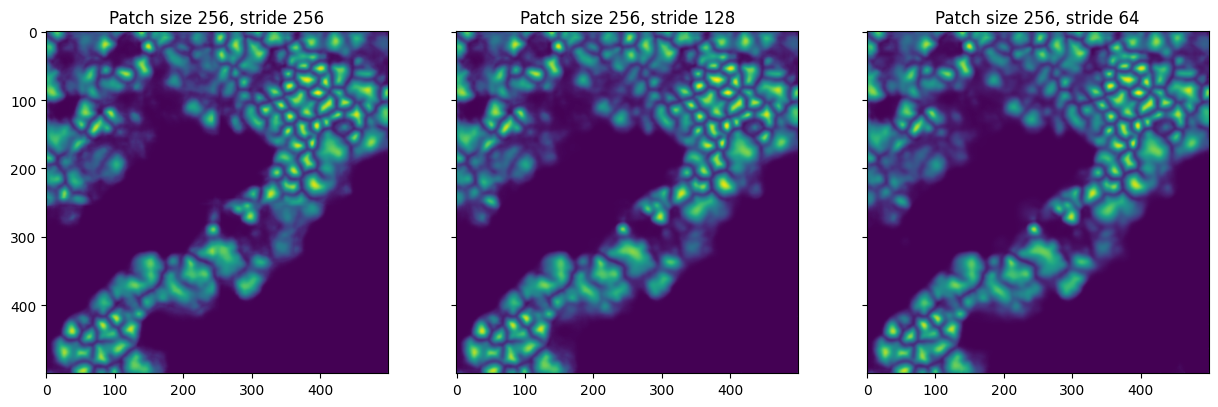

In [10]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
dist = output0[0, 2].cpu().numpy().squeeze()
ax[0].imshow(dist, vmin=0)
ax[0].set_title('Patch size 256, stride 256')

dist = output1[0, 2].cpu().numpy().squeeze()
ax[1].imshow(dist, vmin=0)
ax[1].set_title('Patch size 256, stride 128')

dist = output2[0, 2].cpu().numpy().squeeze()
ax[2].imshow(dist, vmin=0)
ax[2].set_title('Patch size 256, stride 64')

plt.show()

## Very small tile

In [11]:
t = create_raster_tensor(small_tile_path)
t = t[:, :, :96, :96]

/home/k/k202141/.conda/envs/deeptree/lib/python3.12/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [12]:
%time output0 = predict_on_tile(model, t, max_patch_size=256, stride=256)
%time output1 = predict_on_tile(model, t, max_patch_size=256, stride=128)
%time output2 = predict_on_tile(model, t, max_patch_size=256, stride=64)

Stride exceeded patch size, resetting to patch size
Stride exceeded patch size, resetting to patch size


CPU times: user 6.16 s, sys: 141 ms, total: 6.3 s
Wall time: 396 ms
CPU times: user 2.69 s, sys: 0 ns, total: 2.69 s
Wall time: 44.6 ms
CPU times: user 4.82 s, sys: 0 ns, total: 4.82 s
Wall time: 75.3 ms


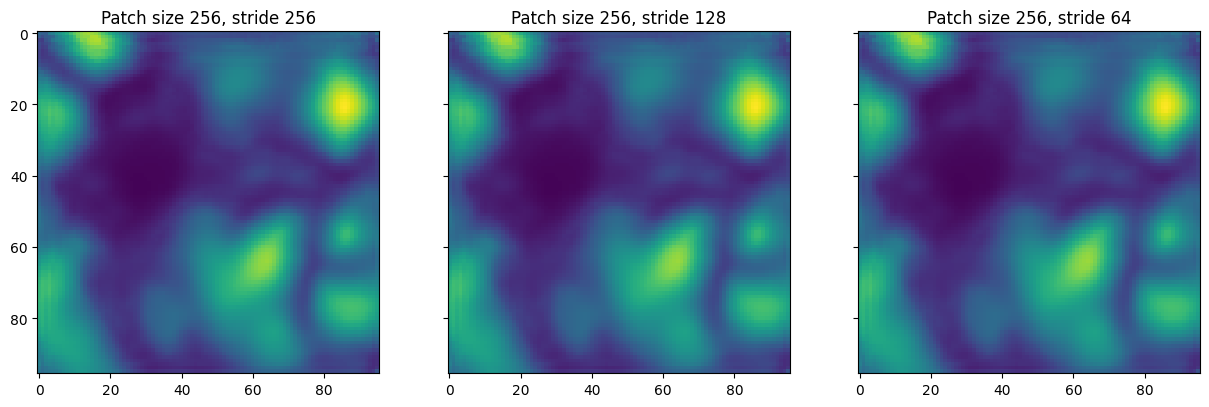

In [13]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
dist = output0[0, 2].cpu().numpy().squeeze()
ax[0].imshow(dist, vmin=0)
ax[0].set_title('Patch size 256, stride 256')

dist = output1[0, 2].cpu().numpy().squeeze()
ax[1].imshow(dist, vmin=0)
ax[1].set_title('Patch size 256, stride 128')

dist = output2[0, 2].cpu().numpy().squeeze()
ax[2].imshow(dist, vmin=0)
ax[2].set_title('Patch size 256, stride 64')

plt.show()

## Rectangular tile

In [14]:
t = create_raster_tensor(small_tile_path)
t = t[:, :, :250, :]

/home/k/k202141/.conda/envs/deeptree/lib/python3.12/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [15]:
t.shape

torch.Size([1, 5, 250, 500])

In [16]:
%time output0 = predict_on_tile(model, t, max_patch_size=256, stride=256)
%time output1 = predict_on_tile(model, t, max_patch_size=256, stride=128)
%time output2 = predict_on_tile(model, t, max_patch_size=256, stride=64)

Stride exceeded patch size, resetting to patch size


CPU times: user 12.9 s, sys: 824 ms, total: 13.7 s
Wall time: 218 ms
CPU times: user 13.2 s, sys: 1.52 s, total: 14.8 s
Wall time: 232 ms
CPU times: user 43.3 s, sys: 12.5 s, total: 55.8 s
Wall time: 935 ms


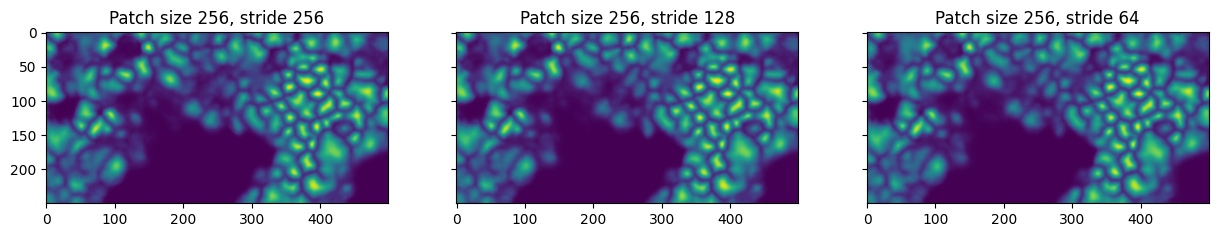

In [17]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
dist = output0[0, 2].cpu().numpy().squeeze()
ax[0].imshow(dist, vmin=0)
ax[0].set_title('Patch size 256, stride 256')

dist = output1[0, 2].cpu().numpy().squeeze()
ax[1].imshow(dist, vmin=0)
ax[1].set_title('Patch size 256, stride 128')

dist = output2[0, 2].cpu().numpy().squeeze()
ax[2].imshow(dist, vmin=0)
ax[2].set_title('Patch size 256, stride 64')

plt.show()

## Large tile

In [18]:
t = create_raster_tensor(large_tile_path)

/home/k/k202141/.conda/envs/deeptree/lib/python3.12/site-packages/xarray/core/concat.py:500: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [19]:
%time output0 = predict_on_tile(model, t, max_patch_size=512, stride=256)
#%time output1 = predict_on_tile(model, t, max_patch_size=256, stride=128)
#%time output2 = predict_on_tile(model, t, max_patch_size=256, stride=64)

CPU times: user 2h 15min 27s, sys: 1h 7min 14s, total: 3h 22min 41s
Wall time: 4min 6s


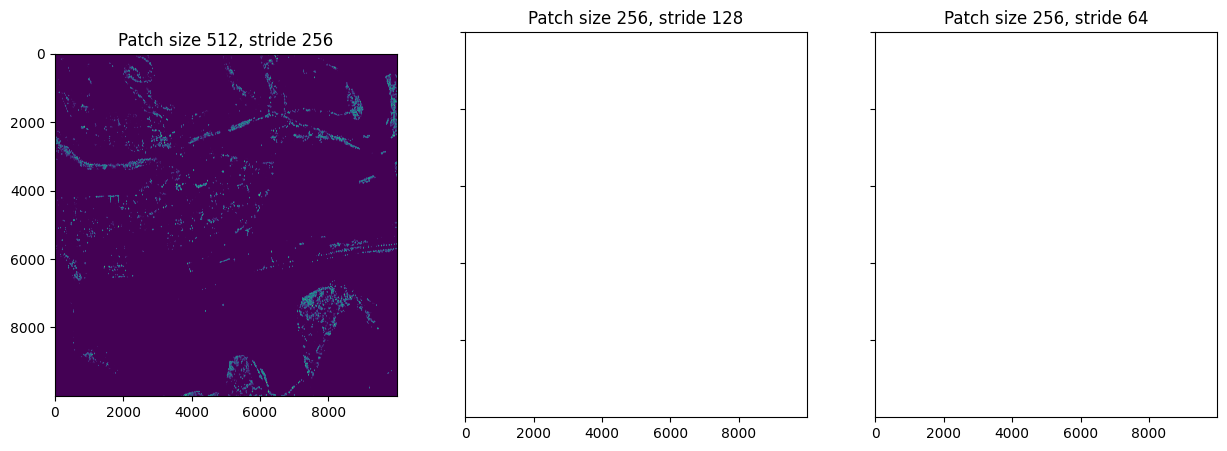

In [28]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
dist = output0[0, 2].cpu().numpy().squeeze()
ax[0].imshow(dist, vmin=0)
ax[0].set_title('Patch size 512, stride 256')

#dist = output1[0, 2].cpu().numpy().squeeze()
#ax[1].imshow(dist, vmin=0)
ax[1].set_title('Patch size 256, stride 128')

#dist = output2[0, 2].cpu().numpy().squeeze()
#ax[2].imshow(dist, vmin=0)
ax[2].set_title('Patch size 256, stride 64')

plt.show()